In [1]:
import pandas as pd
from datasets import load_dataset

dataset = load_dataset("Ozziey/poems_dataset")
df = pd.DataFrame(dataset['train'])
print(df.head())

c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Administrator\.cache\huggingface\hub\datasets--Ozziey--poems_dataset. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode 

                                        poem content  pred    label     score  \
0  Let the bird of loudest lay\r\nOn the sole Ara...     5  sadness  0.650738   
1  Sir Charles into my chamber coming in,\r\nWhen...     0    anger  0.264296   
2  Our vice runs beyond all that old men saw,\r\n...     0    anger  0.758054   
3  Lo I the man, whose Muse whilome did maske,\r\...     0    anger  0.896280   
4  Long have I longd to see my love againe,\r\nSt...     5  sadness  0.600543   

      anger   disgust      fear       joy   neutral   sadness  surprise  \
0  0.133402  0.076618  0.094706  0.006762  0.032960  0.650738  0.004814   
1  0.264296  0.145707  0.057977  0.262715  0.019884  0.244457  0.004963   
2  0.758054  0.210444  0.003690  0.001755  0.013997  0.011483  0.000578   
3  0.896280  0.009259  0.004949  0.002320  0.007623  0.078088  0.001481   
4  0.027077  0.036344  0.075487  0.017212  0.187106  0.600543  0.056230   

           age                  type  
0  Renaissance  Mytholo

In [4]:
import re
import spacy

nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\r\n', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleaned_poem'] = df['poem content'].apply(preprocess_text)

def tokenize_text(text):
    doc = nlp(text)
    return [token.text for token in doc]

df['tokens'] = df['cleaned_poem'].apply(tokenize_text)
print(df[['poem content', 'cleaned_poem', 'tokens']].head())


                                        poem content  \
0  Let the bird of loudest lay\r\nOn the sole Ara...   
1  Sir Charles into my chamber coming in,\r\nWhen...   
2  Our vice runs beyond all that old men saw,\r\n...   
3  Lo I the man, whose Muse whilome did maske,\r\...   
4  Long have I longd to see my love againe,\r\nSt...   

                                        cleaned_poem  \
0  let the bird of loudest lay on the sole arabia...   
1  sir charles into my chamber coming in when i w...   
2  our vice runs beyond all that old men saw and ...   
3  lo i the man whose muse whilome did maske as t...   
4  long have i longd to see my love againe still ...   

                                              tokens  
0  [let, the, bird, of, loudest, lay, on, the, so...  
1  [sir, charles, into, my, chamber, coming, in, ...  
2  [our, vice, runs, beyond, all, that, old, men,...  
3  [lo, i, the, man, whose, muse, whilome, did, m...  
4  [long, have, i, longd, to, see, my, love, agai..

In [16]:
import torch
import torch.nn as nn

def build_vocab(texts):
    word_to_idx = {}
    idx_to_word = {}
    idx = 0
    for text in texts:
        for word in text.split():
            if word not in word_to_idx:
                word_to_idx[word] = idx
                idx_to_word[idx] = word
                idx += 1
    return word_to_idx, idx_to_word

def filter_and_prepare_data(df, emotion):
    poems = df[df['label'] == emotion]['cleaned_poem'].tolist()
    word_to_idx, idx_to_word = build_vocab(poems)
    return poems, word_to_idx, idx_to_word

def sentence_to_indices(sentence, word_to_idx):
    return [word_to_idx[word] for word in sentence.split() if word in word_to_idx]

def generate_text(model, seed_text, word_count, idx_to_word, word_to_idx, device):
    model.eval()
    words = seed_text.split()
    input_indices = torch.tensor([sentence_to_indices(seed_text, word_to_idx)], device=device)

    for _ in range(word_count - len(words)):
        with torch.no_grad():
            output = model(input_indices)
            _, predicted = torch.max(output, dim=1)
            next_word = idx_to_word[predicted.item()]
            words.append(next_word)
            input_indices = torch.tensor([[predicted.item()]], device=device)

    return ' '.join(words)

class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)  # Shape: (batch_size, sequence_length, embed_size)
        out, _ = self.rnn(x)  # Shape: (batch_size, sequence_length, hidden_size)
        out = self.fc(out)  # Shape: (batch_size, sequence_length, vocab_size)
        return out

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, dropout_rate=0.3):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)  # Shape: (batch_size, sequence_length, embed_size)
        out, _ = self.lstm(x)  # Shape: (batch_size, sequence_length, hidden_size)
        out = self.fc(out)  # Shape: (batch_size, sequence_length, vocab_size)
        return out



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Training and Loss Graph

In [17]:
embed_size = 128  # Keep constant for fair comparison
hidden_size_list = [256, 512]  # Experiment with larger hidden states
learning_rate_list = [0.001, 0.0005]  # Experiment with lower learning rates
dropout_rate = 0.3  # Add dropout to reduce overfitting


In [18]:
from sklearn.model_selection import train_test_split

# Split poems into train and validation
train_poems, val_poems = train_test_split(poems, test_size=0.2, random_state=42)

val_loader = prepare_dataloader(val_poems, word_to_idx, batch_size)


In [20]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
import torch
import torch.nn as nn

def prepare_dataloader(poems, word_to_idx, batch_size):
    sequences = [torch.tensor(sentence_to_indices(poem, word_to_idx), dtype=torch.long) for poem in poems]
    inputs = [seq[:-1] for seq in sequences if len(seq) > 1]
    targets = [seq[1:] for seq in sequences if len(seq) > 1]
    
    padded_inputs = pad_sequence(inputs, batch_first=True, padding_value=0)
    padded_targets = pad_sequence(targets, batch_first=True, padding_value=0)
    
    dataset = TensorDataset(padded_inputs, padded_targets)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


def train_and_evaluate(model, optimizer, train_loader, val_loader, loss_fn, epochs=50):
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            max_seq_len = inputs.size(1)
            outputs = outputs[:, :max_seq_len, :]
            outputs = outputs.contiguous().view(-1, outputs.size(-1))
            targets = targets.contiguous().view(-1)

            loss = loss_fn(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        
        train_loss = epoch_loss / len(train_loader)
        train_losses.append(train_loss)

        # Evaluate on validation set
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                max_seq_len = inputs.size(1)
                outputs = outputs[:, :max_seq_len, :]
                outputs = outputs.contiguous().view(-1, outputs.size(-1))
                targets = targets.contiguous().view(-1)
                loss = loss_fn(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_losses, val_losses




In [22]:

epochs = 50
batch_size = 32
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss(ignore_index=0) 

emotion = "joy"
poems, word_to_idx, idx_to_word = filter_and_prepare_data(df, emotion)

vocab_size = len(word_to_idx)

embed_size = 128
hidden_size = 256
output_size = vocab_size

rnn_model = RNNModel(vocab_size, embed_size, hidden_size, output_size).to(device)
lstm_model = LSTMModel(vocab_size, embed_size, hidden_size, output_size).to(device)

optimizer_rnn = torch.optim.Adam(rnn_model.parameters(), lr=learning_rate)
optimizer_lstm = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)

train_loader = prepare_dataloader(poems, word_to_idx, batch_size)

rnn_losses = train_model(rnn_model, optimizer_rnn, train_loader)

lstm_losses = train_model(lstm_model, optimizer_lstm, train_loader)

# plt.plot(rnn_losses, label="RNN Loss", color="red")
# plt.plot(lstm_losses, label="LSTM Loss", color="blue") 
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend()
# plt.title("Training Loss for RNN and LSTM")
# plt.show()



Outputs shape before reshaping: torch.Size([24, 235, 1022])
Targets shape before reshaping: torch.Size([24, 235])
Outputs shape after reshaping: torch.Size([5640, 1022])
Targets shape after reshaping: torch.Size([5640])
Epoch 1/50, Loss: 6.9601
Outputs shape before reshaping: torch.Size([24, 235, 1022])
Targets shape before reshaping: torch.Size([24, 235])
Outputs shape after reshaping: torch.Size([5640, 1022])
Targets shape after reshaping: torch.Size([5640])
Epoch 2/50, Loss: 6.8651
Outputs shape before reshaping: torch.Size([24, 235, 1022])
Targets shape before reshaping: torch.Size([24, 235])
Outputs shape after reshaping: torch.Size([5640, 1022])
Targets shape after reshaping: torch.Size([5640])
Epoch 3/50, Loss: 6.7702
Outputs shape before reshaping: torch.Size([24, 235, 1022])
Targets shape before reshaping: torch.Size([24, 235])
Outputs shape after reshaping: torch.Size([5640, 1022])
Targets shape after reshaping: torch.Size([5640])
Epoch 4/50, Loss: 6.6745
Outputs shape before

In [24]:
rnn_train_losses, rnn_val_losses = train_and_evaluate(rnn_model, optimizer_rnn, train_loader, val_loader, loss_fn)
lstm_train_losses, lstm_val_losses = train_and_evaluate(lstm_model, optimizer_lstm, train_loader, val_loader, loss_fn)

rnn_perplexity = evaluate_perplexity(rnn_model, val_loader, loss_fn)
lstm_perplexity = evaluate_perplexity(lstm_model, val_loader, loss_fn)

print(f"RNN Validation Perplexity: {rnn_perplexity:.4f}")
print(f"LSTM Validation Perplexity: {lstm_perplexity:.4f}")


Epoch 1/50, Train Loss: 2.3077, Val Loss: 2.3477
Epoch 2/50, Train Loss: 2.2256, Val Loss: 2.2638
Epoch 3/50, Train Loss: 2.1444, Val Loss: 2.1815
Epoch 4/50, Train Loss: 2.0649, Val Loss: 2.1008
Epoch 5/50, Train Loss: 1.9872, Val Loss: 2.0216
Epoch 6/50, Train Loss: 1.9110, Val Loss: 1.9446
Epoch 7/50, Train Loss: 1.8369, Val Loss: 1.8692
Epoch 8/50, Train Loss: 1.7643, Val Loss: 1.7959
Epoch 9/50, Train Loss: 1.6939, Val Loss: 1.7242
Epoch 10/50, Train Loss: 1.6252, Val Loss: 1.6545
Epoch 11/50, Train Loss: 1.5586, Val Loss: 1.5865
Epoch 12/50, Train Loss: 1.4938, Val Loss: 1.5204
Epoch 13/50, Train Loss: 1.4311, Val Loss: 1.4563
Epoch 14/50, Train Loss: 1.3702, Val Loss: 1.3943
Epoch 15/50, Train Loss: 1.3112, Val Loss: 1.3341
Epoch 16/50, Train Loss: 1.2542, Val Loss: 1.2757
Epoch 17/50, Train Loss: 1.1990, Val Loss: 1.2193
Epoch 18/50, Train Loss: 1.1456, Val Loss: 1.1649
Epoch 19/50, Train Loss: 1.0941, Val Loss: 1.1122
Epoch 20/50, Train Loss: 1.0444, Val Loss: 1.0612
Epoch 21/

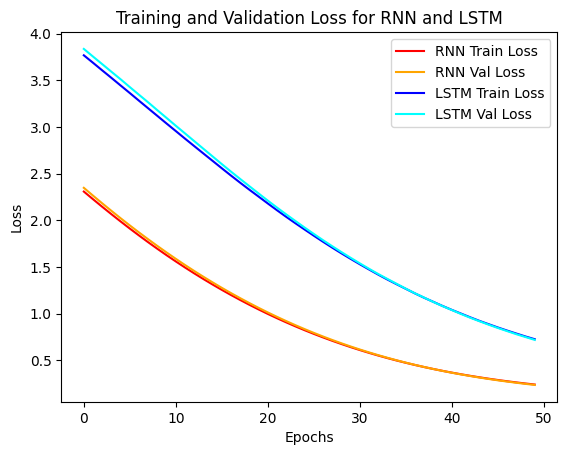

In [25]:
plt.plot(rnn_train_losses, label="RNN Train Loss", color="red")
plt.plot(rnn_val_losses, label="RNN Val Loss", color="orange")
plt.plot(lstm_train_losses, label="LSTM Train Loss", color="blue")
plt.plot(lstm_val_losses, label="LSTM Val Loss", color="cyan")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss for RNN and LSTM")
plt.show()


## Perplexity

In [14]:
def calculate_perplexity(loss):
    return torch.exp(torch.tensor(loss))

# Function to calculate perplexity for a given model
def evaluate_perplexity(model, data_loader, loss_fn):
    model.eval()
    total_loss = 0
    total_words = 0
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Restrict outputs to match targets' sequence length
            max_seq_len = inputs.size(1)
            outputs = outputs[:, :max_seq_len, :]
            
            # Reshape outputs and targets
            outputs = outputs.contiguous().view(-1, outputs.size(-1))
            targets = targets.contiguous().view(-1)
            
            # Compute loss
            loss = loss_fn(outputs, targets)
            total_loss += loss.item() * targets.size(0)  # Multiply by the number of words in batch
            total_words += targets.size(0)
    
    avg_loss = total_loss / total_words  # Average loss per word
    perplexity = calculate_perplexity(avg_loss)  # Compute perplexity
    return perplexity

# Evaluate perplexity for both models
rnn_perplexity = evaluate_perplexity(rnn_model, train_loader, loss_fn)
lstm_perplexity = evaluate_perplexity(lstm_model, train_loader, loss_fn)

print(f"RNN Perplexity: {rnn_perplexity:.4f}")
print(f"LSTM Perplexity: {lstm_perplexity:.4f}")


RNN Perplexity: 9.5672
LSTM Perplexity: 40.8407
